In the previous article, we talked about hypothesis testing using the Welch's t-test on two independent samples of data. So what happens if we want know the statiscal significance for $k$ groups of data?

This is where the analysis of variance technique, or ANOVA is useful.

### ANOVA Assumptions

We'll be looking at SAT scores for five different districts in New York City. Specifically, we'll be using "scores.csv" from [Kaggle](https://www.kaggle.com/nycopendata/high-schools). First let's get the assumptions out of the way:

+ The dependent variable (SAT scores) should be continuous. 
+ The independent variables (districts) should be two or more categorical groups.
+ There must be different participants in each group with no participant being in more than one group. In our case, each school cannot be in more than one district.
+ The dependent variable should be approximately normally distributed for each category.
+ Variances of each group are approximately equal.



### Data Exploration

Let's begin by taking a look at what our data looks like.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

data = pd.read_csv("scores.csv")
data.head()

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,End Time,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
0,02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,...,3:00 PM,87.0,3.4%,21.8%,67.8%,4.6%,NaN,NaN,NaN,NaN
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,4:00 PM,1735.0,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,91.0%
3,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,2:45 PM,358.0,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,78.9%
4,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,3:00 PM,383.0,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,65.1%


In [2]:
data['Borough'].value_counts()

Brooklyn         121
Bronx            118
Manhattan        106
Queens            80
Staten Island     10
Name: Borough, dtype: int64

### Creating New Columns

There is no total score column, so we'll have to create it. In addition, we'll have to find the mean score of the each district across all schools.

Brooklyn_std : 154.8684270520867
Bronx_std : 150.39390071890665
Manhattan_std : 230.29413953637814
Queens_std : 195.25289850192115
Staten Island_std : 222.30359621222706


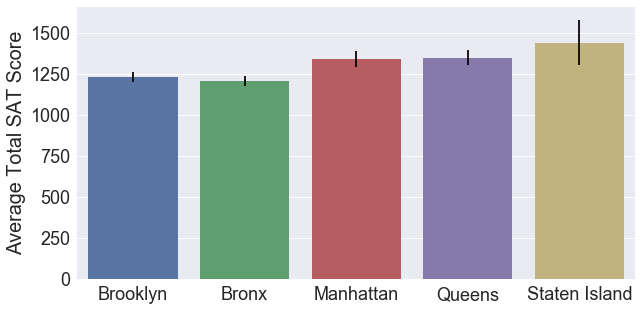

In [3]:
data['total_score'] = data['Average Score (SAT Reading)'] +  \
                      data['Average Score (SAT Math)']    +  \
                      data['Average Score (SAT Writing)']
data = data[['Borough', 'total_score']].dropna()        
x = ['Brooklyn', 'Bronx', 'Manhattan', 'Queens', 'Staten Island']
district_dict = {}

#Assigns each test score series to a dictionary key
for district in x:
    district_dict[district] = data[data['Borough'] == district]['total_score']


y = []
yerror = []
#Assigns the mean score and 95% confidence limit to each district
for district in x:
    y.append(district_dict[district].mean())
    yerror.append(1.96*district_dict[district].std()/np.sqrt(district_dict[district].shape[0]))    
    print(district + '_std : {}'.format(district_dict[district].std()))
    
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x, y, yerr=yerror)
ax.set_ylabel('Average Total SAT Score')
plt.show()

From our data exploration, we can see that the average SAT scores are quite different for each district. We are interested in knowing if this is caused by random variation in data, or if there is an underlying cause. Since we have five different groups, we cannot use the t-test. Also note that the standard deviation of each group are also very different, so we've violated one of our assumpions. However, we are going to use the 1-way ANOVA test anyway just to understand the concepts.

### The Null and Alternative Hypothesis

There are no significant differences between the groups' mean SAT scores.

$ H_0 : \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5 $

There is a significant difference between the groups' mean SAT scores.

$ H_a : \mu_i \ne \mu_j $

Where  $\mu_i$ and $\mu_j$ can be the mean of any group. If there is at least one group with a significant difference with another group, the null hypothesis will be rejected.

### 1-way ANOVA

Similar to the t-test, we can calculate a score for the ANOVA. Then we can look up the score in the F-distribution and obtain a p-value.

The F-statistic is defined as follows:

$$ F = \frac{MS_{b}} {MS_w} $$

$$ MS_{b} = \frac{SS_{b}} {K-1}$$

$$ MS_{w} = \frac{SS_{w}} {N-K}$$

$$ SS_{b} = {n_k\sum(\bar{x_{k}}-\bar{x_{G}})^2} $$

$$ SS_{w} = \sum(x_{i}-\bar{x_{k}})^2 $$

Where $MS_{b}$ is the estimated variance between groups and $MS_{w}$ is the estimated variance within groups, $\bar{x_{k}}$ is the mean within each group, $n_k$ is the sample size for each group, ${x_i}$ is the individual data point, and $\bar{x_{G}}$ is the total mean. 

This is quite a lot of math, fortunately scipy has a function that plugs in all the values for us. The documentation for calculating 1-way ANOVA using scipy is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html). 

In [4]:
stats.f_oneway(
             district_dict['Brooklyn'], district_dict['Bronx'], \
             district_dict['Manhattan'], district_dict['Queens'], \
             district_dict['Staten Island']
)

F_onewayResult(statistic=12.733085029201668, pvalue=1.0161974965566023e-09)

The resulting pvalue was less than 0.05. We can reject the null hypothesis and conclude that there is a significant difference between the SAT scores for each district. Even though we've obtained a very low p-value, we cannot make any assumptions about the magnitude of the effect. Also scipy does not calculate $SS_b$ and $SS_w$, so it is probably better to write our own code.

In [5]:
districts = ['Brooklyn', 'Bronx', 'Manhattan', 'Queens', 'Staten Island']

ss_b = 0
for d in districts:
    ss_b += district_dict[d].shape[0] * \
            np.sum((district_dict[d].mean() - data['total_score'].mean())**2)

ss_w = 0
for d in districts:
    ss_w += np.sum((district_dict[d] - district_dict[d].mean())**2)

msb = ss_b/4
msw = ss_w/(len(data)-5)
f=msb/msw
print('F_statistic: {}'.format(f))

F_statistic: 12.733085029201687


### The Effect Size

We can calculate the magnitude of the effect to determine how large the difference is. One of the measures we can use is Eta-squared.


$$ \eta^2 = \frac{SS_{b}} {SS_{total}}$$

$$ SS_{b} = {n_k\sum(\bar{x_{k}}-\bar{x_{G}})^2} $$

$$ SS_{total} = \sum(x_{i}-\bar{x_{G}})^2 $$

In [6]:
ss_t = np.sum((data['total_score']-data['total_score'].mean())**2)        
eta_squared = ss_b/ss_t
print('eta_squared: {}'.format(eta_squared))

eta_squared: 0.12099887621529214


The general rules of thumb given by Cohen and Miles & Shevlin (2001) for analyzing eta-squared, $\eta^2$:

+ Small effect: $ 0.01 $
+ Medium ffect: $ 0.06 $
+ Large effect: $ 0.14 $

From our calculations, the effect size for this ANOVA test would be "Medium". For a full write up on effect sizes click [here](http://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/effectSize).

---

The files used for this article can be found in my [GitHub repository](https://github.com/sengkchu/codingdisciple.content/tree/master/Learning%20data%20science/Learning/Studying%20Statistics/Hypothesis%20Testing%20ANOVA).